##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [333]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [334]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [335]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [336]:
df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [337]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [338]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [339]:
#Print few rows of tne dataframe using head method
print(df.head())

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


**Columns:**

X: Represents the latitude of the location where the incident was reported.

Y: Represents the longitude of the location where the incident was reported.

Area_Command: This column contains the area-of-command code, which is the police designation of the bureau responsible for handling the incident.

NIBRSOffenseCode: This column contains the classification code for the type of crime committed.

DayOfWeek: This column represents the day of the week on which the incident was reported.

Time: This column represents the hour of the day when the incident was reported.

VictimCount: This is the target variable. It represents the number of persons involved in the incident.

**Range of values in each column:**

X and Y: These columns represent geographical coordinates. They may need to be scaled or normalized if their values cover a wide range.

Area_Command: This column contains categorical data. It has a limited set of unique values.

NIBRSOffenseCode: This column contains categorical data. The range of values depends on the specific codes used in the dataset.

DayOfWeek and Time: Values are typically integers within a certain range (e.g., 0 to 6 for DayOfWeek and 0 to 23 for Time).

VictimCount: This is the target variable representing the number of persons involved. It has been factorized, and its values will be integers.

The input variables are X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, and Time, while the target variable is VictimCount.

## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [340]:
import torch
from sklearn.model_selection import train_test_split

# Define your input features (X) and output variable (Y)
X = torch.tensor(df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']].values.astype(np.float32))
Y = torch.tensor(df['VictimCount'].values.astype(np.float32))

# Split the data into training and testing sets (e.g., 80% for training, 20% for testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define batch size
batch_size = 32

# Create DataLoader objects for training and testing
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Verify the shape of the data by iterating over one DataLoader (e.g., train_loader)
for batch in train_loader:
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print("Output shape:", targets.shape)
    break

Input shape: torch.Size([32, 6])
Output shape: torch.Size([32])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [341]:
#1.For a regression problem, Mean Squared Error (MSE) is a common choice for the loss function.
#It quantifies the average squared difference between predicted values and actual target values.

criterion = torch.nn.MSELoss()

#2.Since this is a regression problem, the size of the predicted output should be 1, representing the predicted number of crime victims.

#3.The architecture might consist of an input layer with as many neurons as there are input features, one or more hidden layers, and an output layer with a single neuron for the regression output.
#The exact number of hidden layers and neurons in each layer can be tuned during experimentation.

class RegressionModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.layer1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

input_size = 6
output_size = 1
hidden_size=64
model = RegressionModel(input_size,hidden_size, output_size)

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# This loop will go through batches of data, perform forward and backward passes, and update the weights of the network.
num_epochs = 180
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        total_loss += criterion(predictions, batch_y).item()
    average_mse = total_loss / len(test_loader)
    print(f'Epoch [{epoch + 1}], MSE Loss: {average_mse:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [1], MSE Loss: 328.1636
Epoch [2], MSE Loss: 304.0138
Epoch [3], MSE Loss: 281.1041
Epoch [4], MSE Loss: 259.4664
Epoch [5], MSE Loss: 239.0978
Epoch [6], MSE Loss: 220.0332
Epoch [7], MSE Loss: 202.2022
Epoch [8], MSE Loss: 185.5630
Epoch [9], MSE Loss: 170.0770
Epoch [10], MSE Loss: 155.6901
Epoch [11], MSE Loss: 142.3350
Epoch [12], MSE Loss: 129.9492
Epoch [13], MSE Loss: 118.4891
Epoch [14], MSE Loss: 107.9091
Epoch [15], MSE Loss: 98.1288
Epoch [16], MSE Loss: 89.1482
Epoch [17], MSE Loss: 80.8943
Epoch [18], MSE Loss: 73.2934
Epoch [19], MSE Loss: 66.3502
Epoch [20], MSE Loss: 59.9851
Epoch [21], MSE Loss: 54.1627
Epoch [22], MSE Loss: 48.8673
Epoch [23], MSE Loss: 44.0611
Epoch [24], MSE Loss: 39.6711
Epoch [25], MSE Loss: 35.7153
Epoch [26], MSE Loss: 32.1241
Epoch [27], MSE Loss: 28.8790
Epoch [28], MSE Loss: 25.9587
Epoch [29], MSE Loss: 23.3376
Epoch [30], MSE Loss: 20.9827
Epoch [31], MSE Loss: 18.8860
Epoch [32], MSE Loss: 17.0048
Epoch [33], MSE Loss: 15.3293
Epoch

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

In [342]:
#the number of classes is the count of unique values in the 'VictimCount' column

num_classes = len(df['VictimCount'].unique())

#The architecture of the neural network will differ from the regression task. The output layer should have as many neurons as there are classes,
#and a suitable activation function (e.g., Softmax) to the output layer to obtain class probabilities.

#A common choice for multi-class classification is Cross-Entropy Loss. The loss function measures the dissimilarity between predicted class probabilities and actual class labels.
criterion = torch.nn.CrossEntropyLoss()

class ClassificationModel(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.layer_1 = torch.nn.Linear(input_size, 20)
        self.layer_2 = torch.nn.Linear(20, 10)
        self.layer_3 = torch.nn.Linear(10, 5)
        self.layer_4 = torch.nn.Linear(5, num_classes)
        self.softmax = torch.nn.Softmax(dim=1)  # Softmax activation for multi-class classification

    def forward(self, x):
        a_1 = self.layer_1(x)
        h_1 = self.activation_function(a_1)
        a_2 = self.layer_2(h_1)
        h_2 = self.activation_function(a_2)
        a_3 = self.layer_3(h_2)
        h_3 = self.activation_function(a_3)
        a_4 = self.layer_4(h_3)
        pred_output = self.softmax(a_4)
        return pred_output


correct = 0
total = 0

num_epochs = 180
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()
    for batch_X, batch_y in test_loader:
      predictions = model(batch_X)
      _, predicted = torch.max(predictions, 1)  # Get the class with the highest probability
      total += batch_y.size(0)
      correct += (predicted == batch_y).sum().item()
      accuracy = 100 * correct / total
      print(f'Epoch [{epoch + 1}], Accuracy: {accuracy:.2f}%')


Epoch [1], Accuracy: 62.50%
Epoch [1], Accuracy: 54.55%
Epoch [2], Accuracy: 57.47%
Epoch [2], Accuracy: 54.55%
Epoch [3], Accuracy: 56.34%
Epoch [3], Accuracy: 54.55%
Epoch [4], Accuracy: 55.84%
Epoch [4], Accuracy: 54.55%
Epoch [5], Accuracy: 55.56%
Epoch [5], Accuracy: 54.55%
Epoch [6], Accuracy: 55.37%
Epoch [6], Accuracy: 54.55%
Epoch [7], Accuracy: 55.25%
Epoch [7], Accuracy: 54.55%
Epoch [8], Accuracy: 55.16%
Epoch [8], Accuracy: 54.55%
Epoch [9], Accuracy: 55.08%
Epoch [9], Accuracy: 54.55%
Epoch [10], Accuracy: 55.03%
Epoch [10], Accuracy: 54.55%
Epoch [11], Accuracy: 54.98%
Epoch [11], Accuracy: 54.55%
Epoch [12], Accuracy: 54.95%
Epoch [12], Accuracy: 54.55%
Epoch [13], Accuracy: 54.91%
Epoch [13], Accuracy: 54.55%
Epoch [14], Accuracy: 54.89%
Epoch [14], Accuracy: 54.55%
Epoch [15], Accuracy: 54.86%
Epoch [15], Accuracy: 54.55%
Epoch [16], Accuracy: 54.84%
Epoch [16], Accuracy: 54.55%
Epoch [17], Accuracy: 54.82%
Epoch [17], Accuracy: 54.55%
Epoch [18], Accuracy: 54.81%
Epo

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

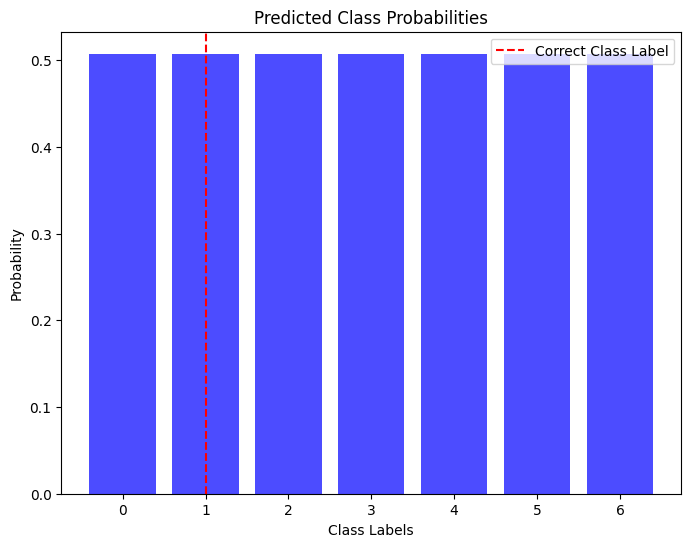

Misclassified Example: [-115.16148   36.11771    4.         1.         5.         9.     ]
Correct Class Label: 1
Predicted Class Label: 0


In [348]:
# In tasks 3 and 4, we addressed two different types of machine learning problems: regression and classification.
# Task 3 focused on predicting a real number, specifically the number of crime victims. We used a regression model and Mean Squared Error (MSE) loss function.
# Task 4, on the other hand, involved classifying the number of crime victims into one of seven categories. We employed a classification model with a softmax activation function and Cross Entropy loss.

# Comparing the results, the classification task (Task 4) worked better for this particular problem.
# This is likely because classifying into predefined categories was more suitable as the VictimCount column has discrete values.
# The classification model provides a clearer understanding of different victim count groups and its relationship with input features.


import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

misclassified_example = None
correct_label = None
predicted_label = None
predicted_probabilities = None

for batch_X, batch_y in test_loader:
    predictions = model(batch_X)
    _, predicted = torch.max(predictions, 1)

    # Find the first misclassified example
    for i in range(len(batch_y)):
        if predicted[i] != batch_y[i]:
            misclassified_example = batch_X[i].numpy()
            correct_label = int(batch_y[i])
            predicted_label = int(predicted[i])
            predicted_probabilities = predictions[i].detach().numpy()
            break

# Create a bar chart for predicted probabilities
classes = df['VictimCount'].unique()
plt.figure(figsize=(8, 6))
plt.bar(classes, predicted_probabilities, color='blue', alpha=0.7)
plt.xlabel('Class Labels')
plt.ylabel('Probability')
plt.title('Predicted Class Probabilities')
plt.xticks(classes)
plt.axvline(x=correct_label, color='red', linestyle='--', label='Correct Class Label')
plt.legend()
plt.show()

print(f'Misclassified Example: {misclassified_example}')
print(f'Correct Class Label: {correct_label}')
print(f'Predicted Class Label: {predicted_label}')



## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


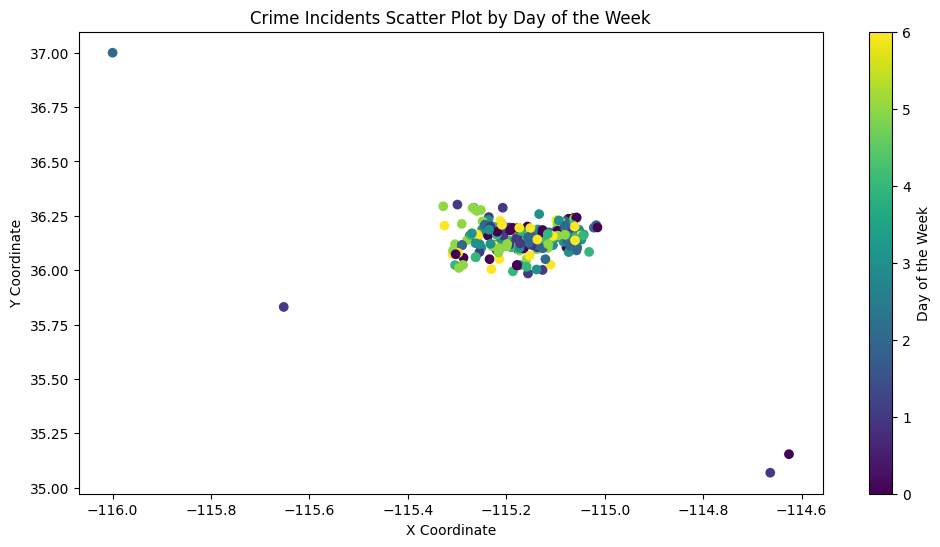

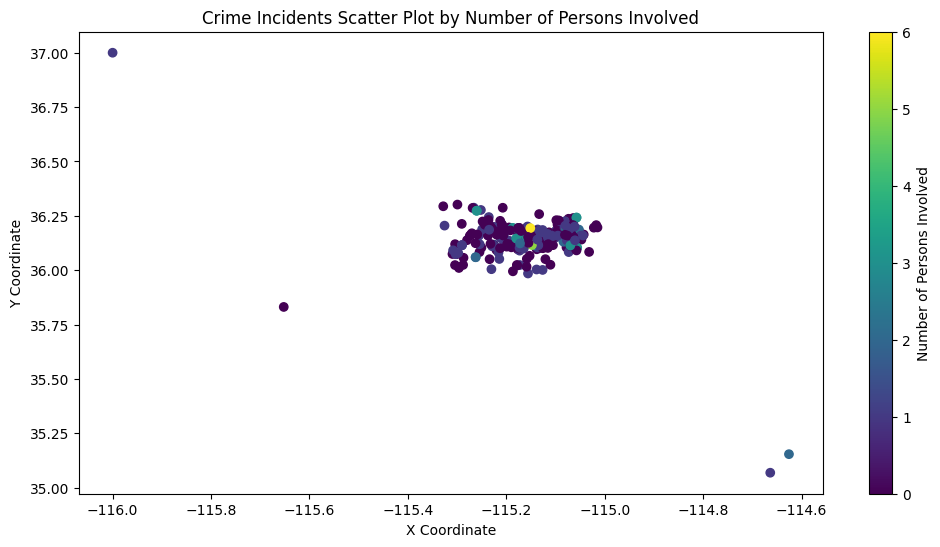

Most frequent days for reported crimes:
  Day of the Week  Count
0          Monday     40
1         Tuesday     37
2       Wednesday     32
3        Thursday     44
4          Friday     51
5        Saturday     43
6          Sunday     28


In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Scatter plot by day of the week
day_of_week_colors = df['DayOfWeek']

plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=day_of_week_colors, cmap='viridis')
plt.colorbar(label='Day of the Week')
plt.title('Crime Incidents Scatter Plot by Day of the Week')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

#Scatter plot by number of persons involved
persons_involved_colors = df['VictimCount']

plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=persons_involved_colors, cmap='viridis')
plt.colorbar(label='Number of Persons Involved')
plt.title('Crime Incidents Scatter Plot by Number of Persons Involved')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

#Sort and count the number of crimes reported by the day of the week
day_of_week_counts = df['DayOfWeek'].value_counts()
day_of_week_counts = day_of_week_counts.sort_index()

# Mapping day of the week index to actual day names
day_of_week_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a DataFrame to display the sorted counts
sorted_day_of_week_counts = pd.DataFrame({'Day of the Week': day_of_week_names, 'Count': day_of_week_counts})

print('Most frequent days for reported crimes:')
print(sorted_day_of_week_counts)
